In [1]:
import os
import sys
sys.path.append("../") # go to parent dir
import glob
import time
import pathlib
import logging
import numpy as np
from scipy.sparse import linalg as spla
from dedalus.tools.config import config
from simple_sphere import SimpleSphere, TensorField, TensorSystem
import equations
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
from dedalus.extras import plot_tools
import logging
from mpl_toolkits import mplot3d
logger = logging.getLogger(__name__) 
from matplotlib.animation import FFMpegWriter

STRNAME = "sphere66"
#add path to data folder
input_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/data"
output_folder = "/Users/Rohit/Documents/research/active_matter_spheres/scripts/garbage"
#input_folder = "data/sphere18"
#output_folder = "images/sphere18"
first_frame = 1
last_frame = len(glob.glob1('%s/%s/' %(input_folder, STRNAME),"*.npz"))
#last_frame = 1000
dpi = 256
fields = ['v_ph']

# Setup output folder
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

t_arr = np.zeros(last_frame)
print('Total time stamps = %i' %(last_frame))


Total time stamps = 2000


2019-07-11 10:23:27,908 matplotlib.animation 0/1 INFO :: MovieWriter.run: running command: ['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '1800x1200', '-pix_fmt', 'rgba', '-r', '15', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-metadata', 'title=Movie', '-metadata', 'artist=Matplotlib', '-metadata', 'comment=Movie support!', '-y', '../videos/sphere50_om_waves.mp4']


KeyboardInterrupt: 

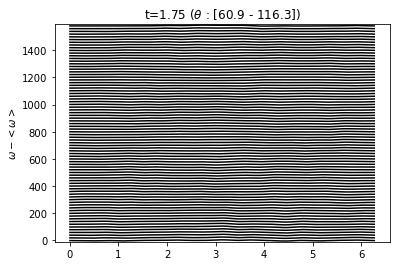

In [2]:
with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, 1)) as file:
    phi = file['phi']
    theta = file['theta']
    
field = 'om'

th_pt = np.linspace(1.3,1.9,15)
#th_inds = [np.abs(theta-th).argmin() for th in th_pt]
th_inds = np.arange(90, 170, 1, dtype=int)
#th_inds = [122, 123, 124, 125]

if field == 'v_ph': vmax = 0.5
elif field =='om': vmax = 10

fig = plt.figure()
metadata = dict(title='Movie', artist='Matplotlib', comment='Movie support!')
writer = FFMpegWriter(fps=15, metadata=metadata)

with writer.saving(fig, "../videos/%s_%s_waves.mp4" %(STRNAME, field), 300):

    for ind in range(first_frame, last_frame + 1, 1):
        if np.mod(ind,100)==0: logger.info('Frame:%i'%(ind))

        with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, ind)) as file:
            plt.cla()
            phi = file['phi']
            theta = file['theta']
            temp = file[field]
            time = file['t'][0]
            t_arr[ind-1] = time
            
            count = 0
            for i in th_inds:
                temp_lat = temp[:,i]
                temp_lat = temp_lat - np.mean(temp_lat)
                plt.plot(phi, temp_lat + count*2*vmax, color='k')
                count += 1

            plt.ylim([-vmax, (2*len(th_inds)-1)*vmax])
            plt.title(r't=%0.2f ($\theta$ : [%0.1f - %0.1f])' %(time, theta[th_inds[-1]]*180/np.pi, theta[th_inds[0]]*180/np.pi))
            if field=='v_ph': plt.ylabel(r'$v_{\phi} - <v_{\phi}>$')
            elif field=='om': plt.ylabel(r'$\omega - <\omega>$')
            #display.clear_output(wait=True)
            #display.display(fig)
            writer.grab_frame()

In [ ]:
import io
import base64
from IPython.display import HTML

field = 'om'

video = io.open('../videos/%s_%s_waves.mp4' %(STRNAME, field), 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video alt="test" width="500" height="350" controls>
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

In [19]:
#Find DFT 
last_frame = len(glob.glob1('%s/%s/' %(input_folder, STRNAME),"*.npz"))
with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, 1)) as file:
        phi = file['phi']
        theta = file['theta']

sig_eq = np.zeros((last_frame, phi.shape[0]))
t_arr = np.zeros(last_frame)
mean_vph = np.zeros(last_frame)

#ind_th = int(len(theta)/2)
ind_th = 50

for ind in range(first_frame, last_frame + 1, 1):
    with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, ind)) as file:
        phi = file['phi']
        theta = file['theta']
        v_ph = file['v_ph']
        time = file['t'][0]
        t_arr[ind-1] = time
        #sig_eq[ind-1, :] = v_ph[:,int(len(theta)/2)] - np.mean(v_ph[:,int(len(theta)/2)])
        sig_eq[ind-1, :] = v_ph[:,ind_th]
        mean_vph[ind-1] = np.mean(v_ph[:,ind_th])
    
sig_fft = np.fft.fft2(sig_eq[500:1000, :])
sig_fft = np.fft.fftshift(sig_fft)
dphi = phi[2] - phi[1]
dt = t_arr[2] - t_arr[1]

phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
time_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[500:1000]), d=dt))


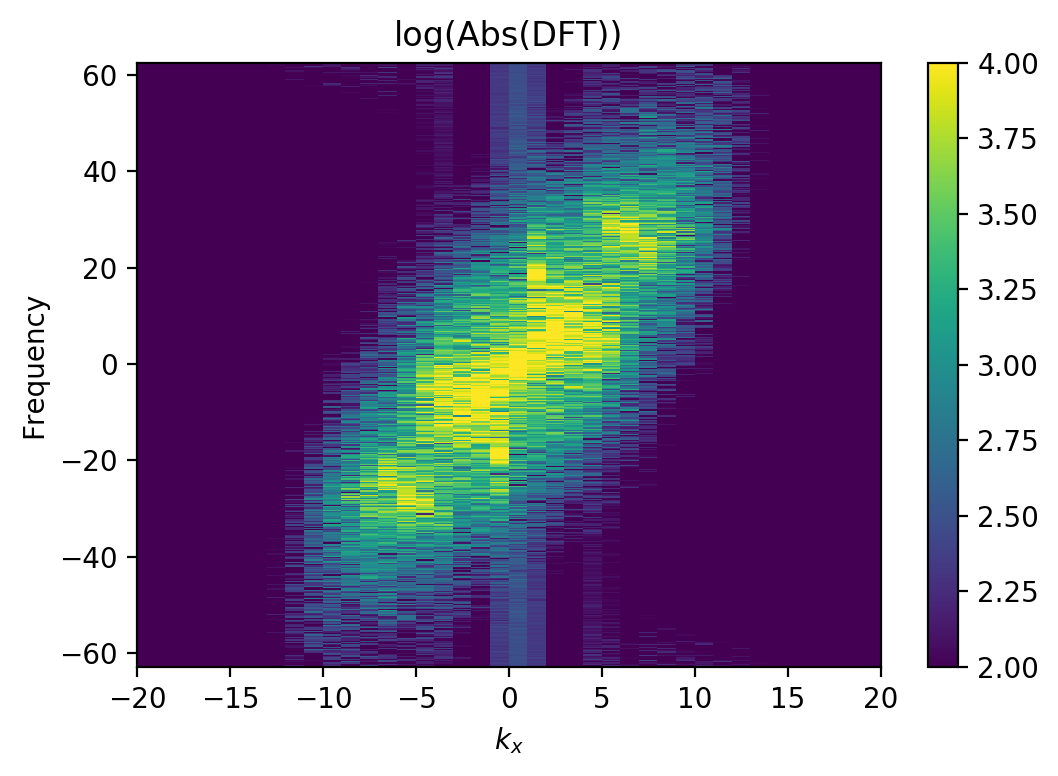

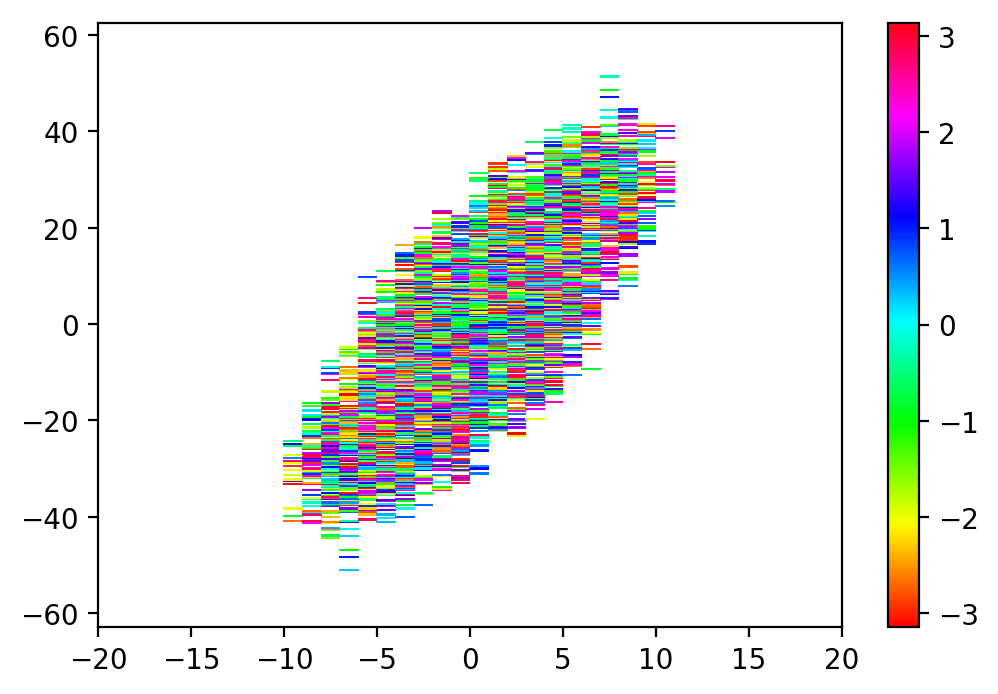

In [25]:
plt.figure(dpi=200)
plt.pcolormesh(phi_freq, time_freq, np.log10(np.abs(sig_fft)), vmin=2, vmax=4)
inds = np.where(np.log10(np.abs(sig_fft)) > 3)

plt.xlim([-20,20])
plt.colorbar()
plt.xlabel(r'$k_x$'); plt.ylabel('Frequency')
plt.title('log(Abs(DFT))')
#plt.savefig('DFT_waves.png')

angle = np.where(np.log10(np.abs(sig_fft))>3, np.angle(sig_fft), np.nan)
plt.figure(dpi=200)
plt.pcolormesh(phi_freq, time_freq, angle, cmap='hsv')
plt.xlim([-20,20]); plt.colorbar()



(-10, 10)

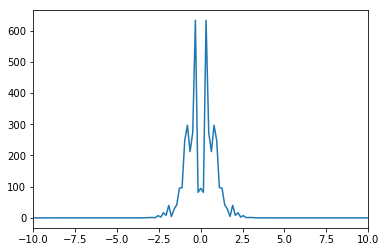

In [26]:
sig_fft = np.fft.fftshift(np.fft.fft(sig_eq[100,:]))
plt.plot(phi_freq, np.abs(sig_fft))
plt.xlim(-10,10)

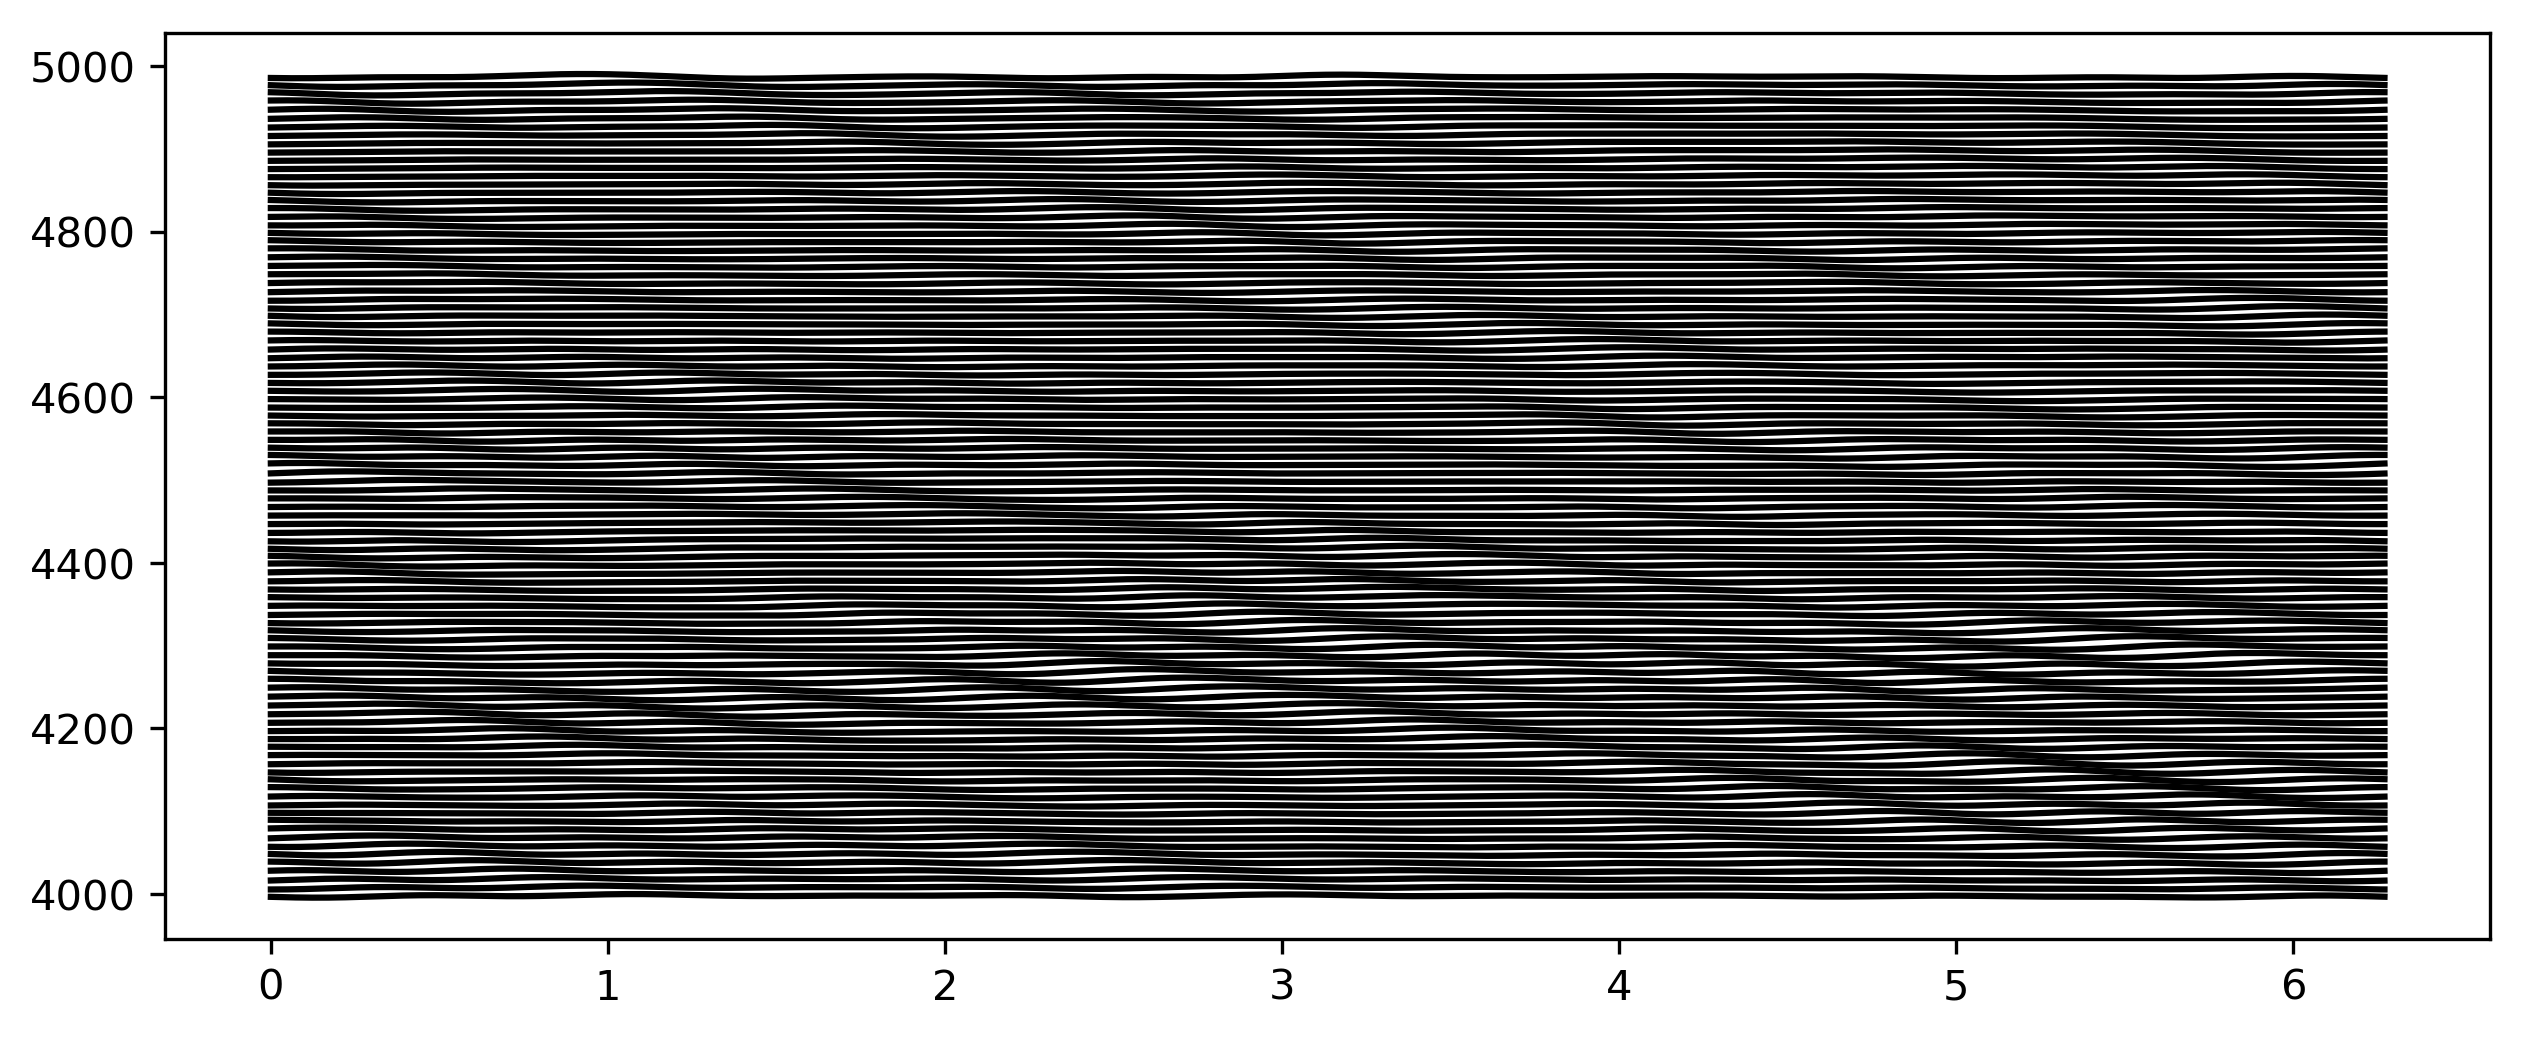

In [27]:
plt.figure(figsize=(10,4), dpi=300)
for i in range(400,500):
    plt.plot(phi, sig_eq[i,:]+i*10, color='k')

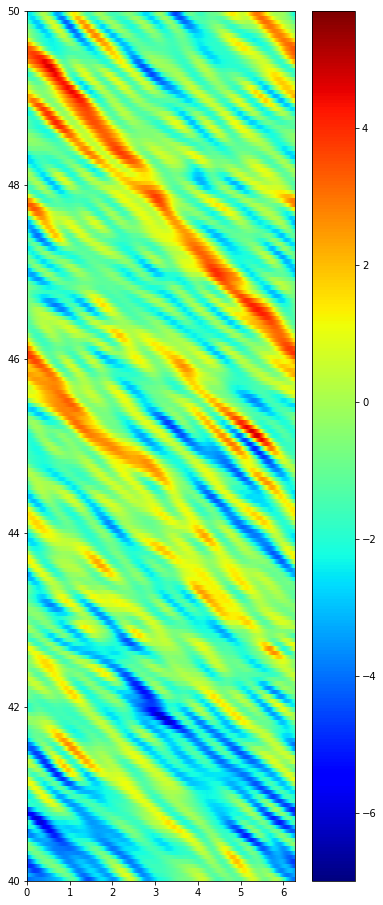

In [28]:
plt.figure(figsize=(6,16))
plt.pcolormesh(phi, t_arr, sig_eq, cmap='jet')
plt.ylim([40,50])
plt.colorbar()
plt.savefig('waves_equator.png')

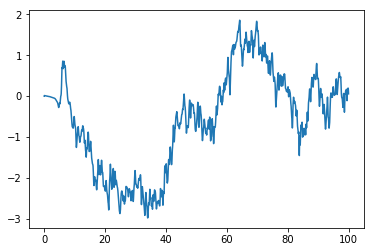

In [29]:
%matplotlib inline
plt.plot(t_arr, mean_vph)

## Find Rossby number of the simulations

In [30]:
speed = np.zeros((last_frame, phi.shape[0], theta.shape[0]))
                 
for ind in range(first_frame, last_frame + 1, 1):
    with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, ind)) as file:
        speed[ind-1, :, :] = np.sqrt(file['v_ph']**2 + file['v_th']**2)
        
np.max(speed)/150    

0.05049190366418001

### Plot velocity at different latitudes

In [5]:
vph = np.zeros((last_frame, phi.shape[0], theta.shape[0]))
                 
for ind in range(first_frame, last_frame + 1, 1):
    with np.load('%s/%s/output_%i.npz' %(input_folder, STRNAME, ind)) as file:
        vph[ind-1, :, :] = file['v_ph']       

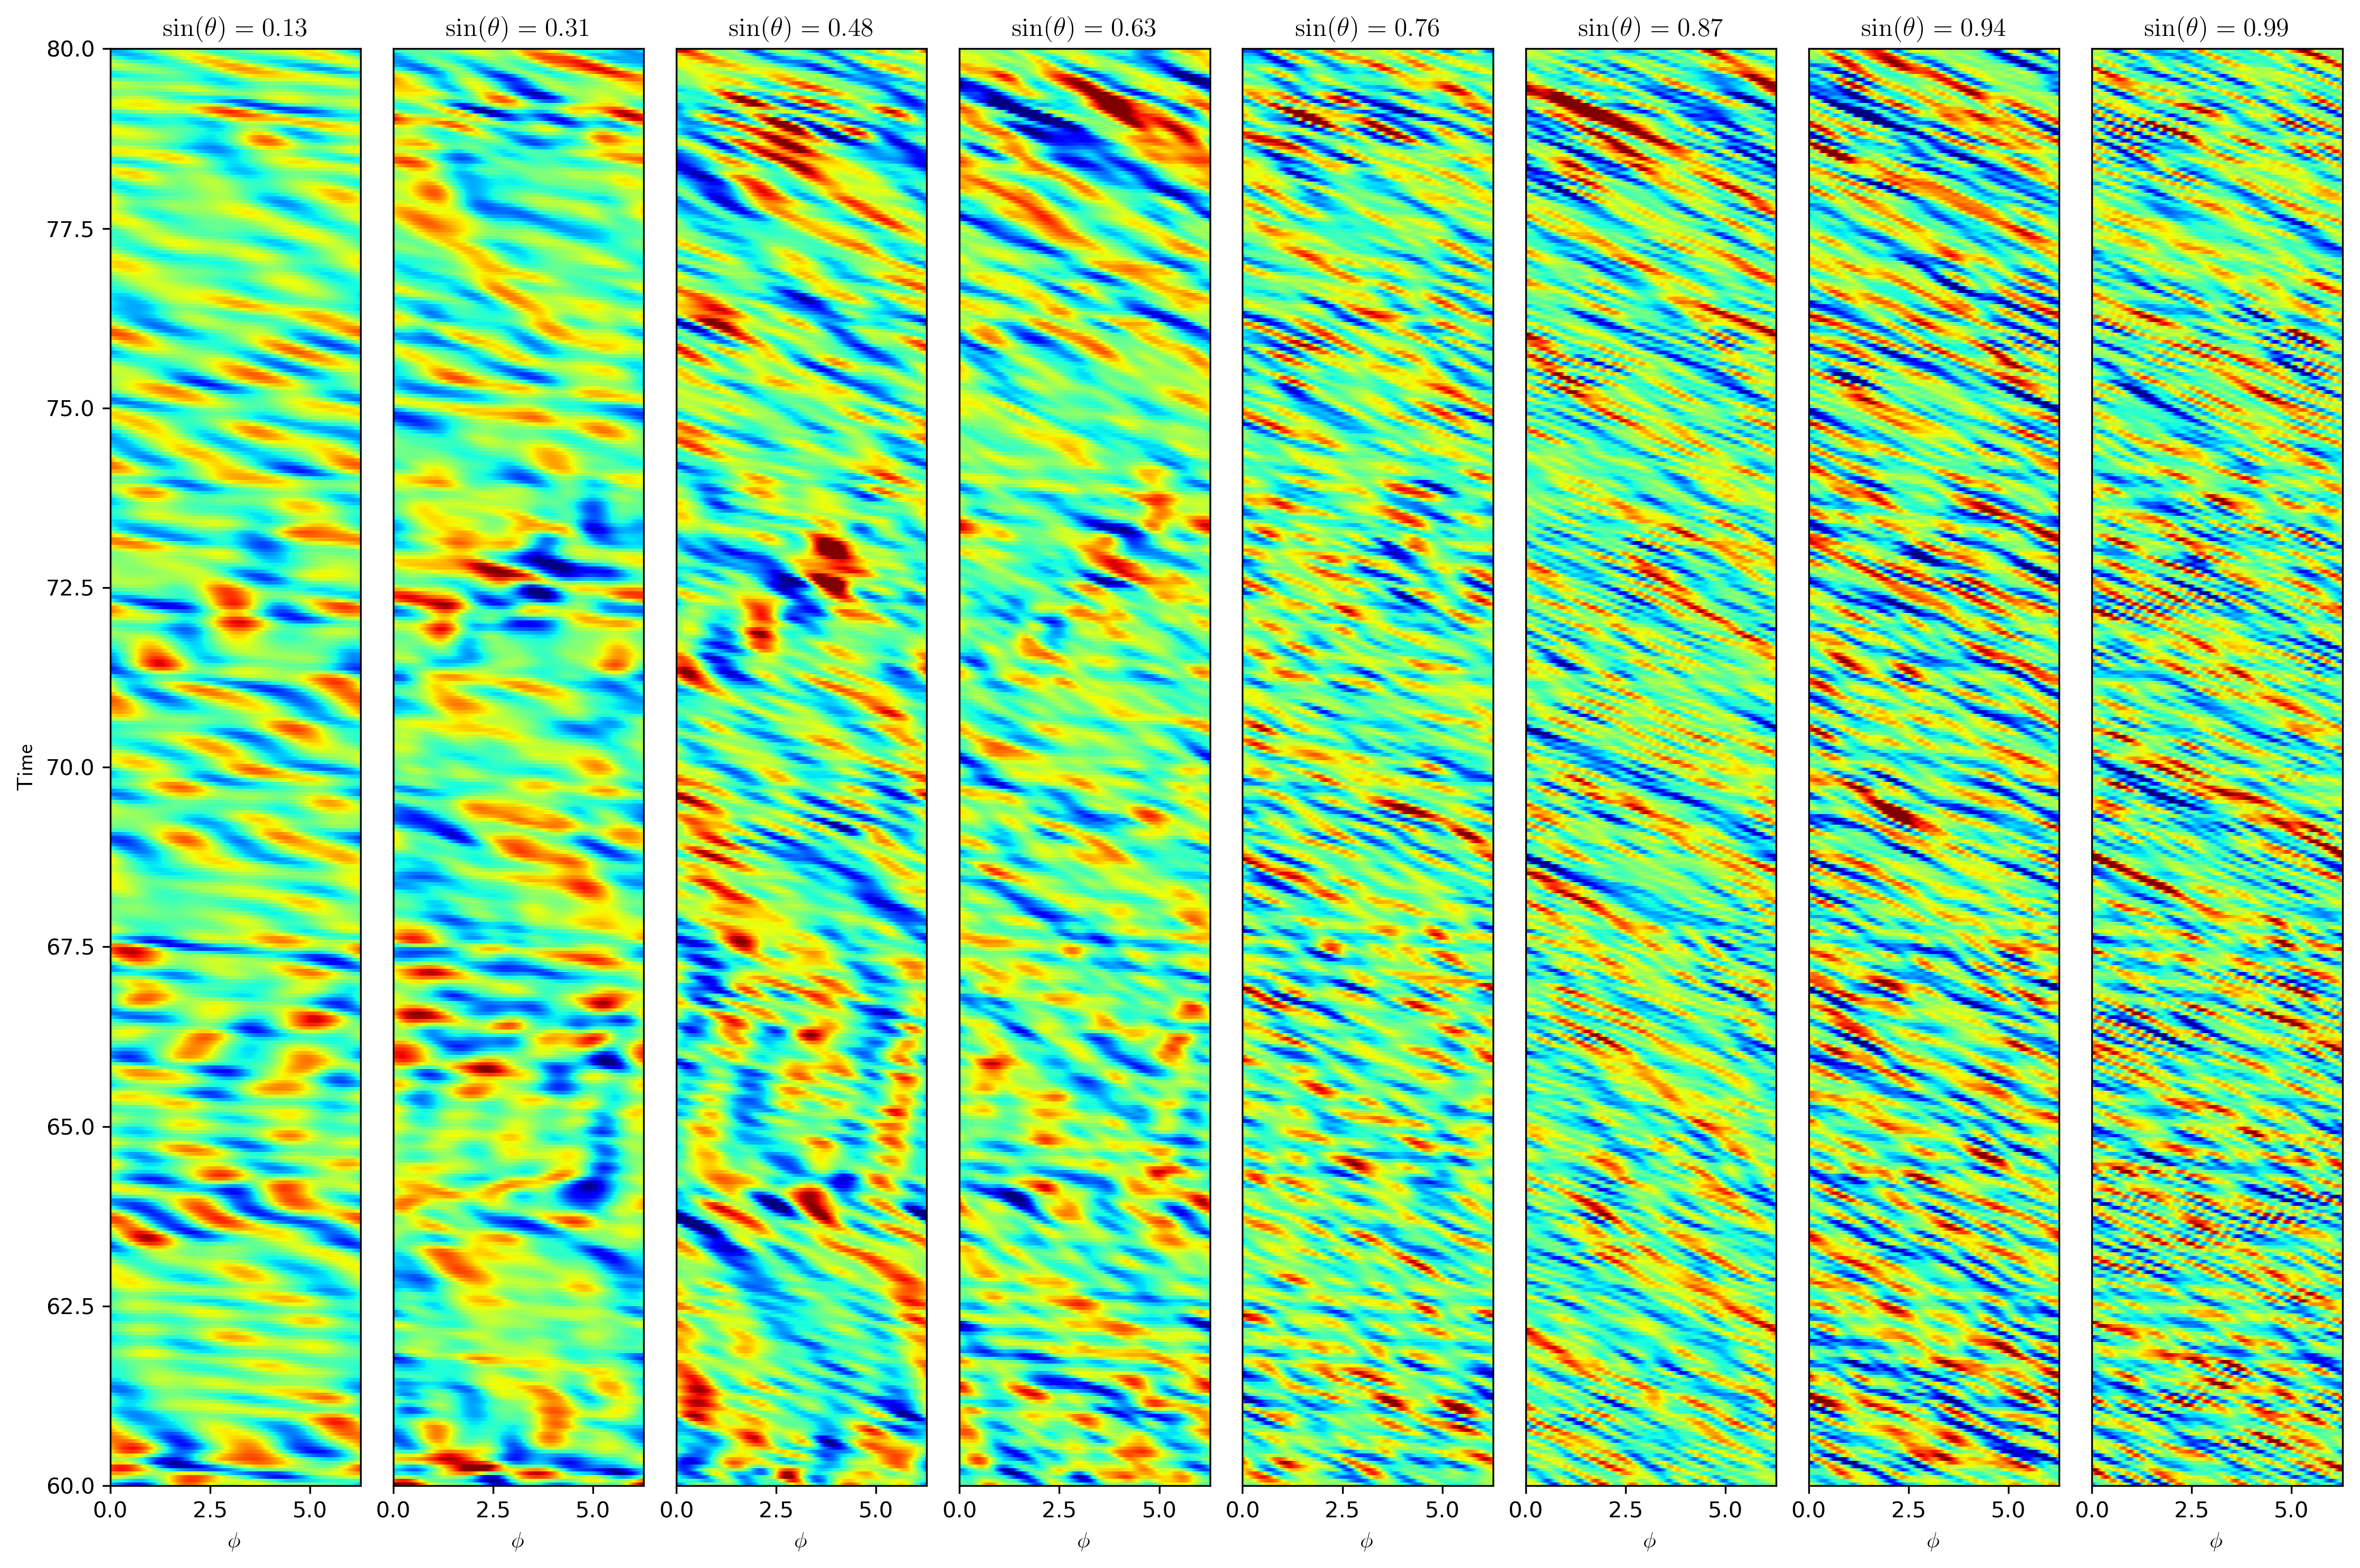

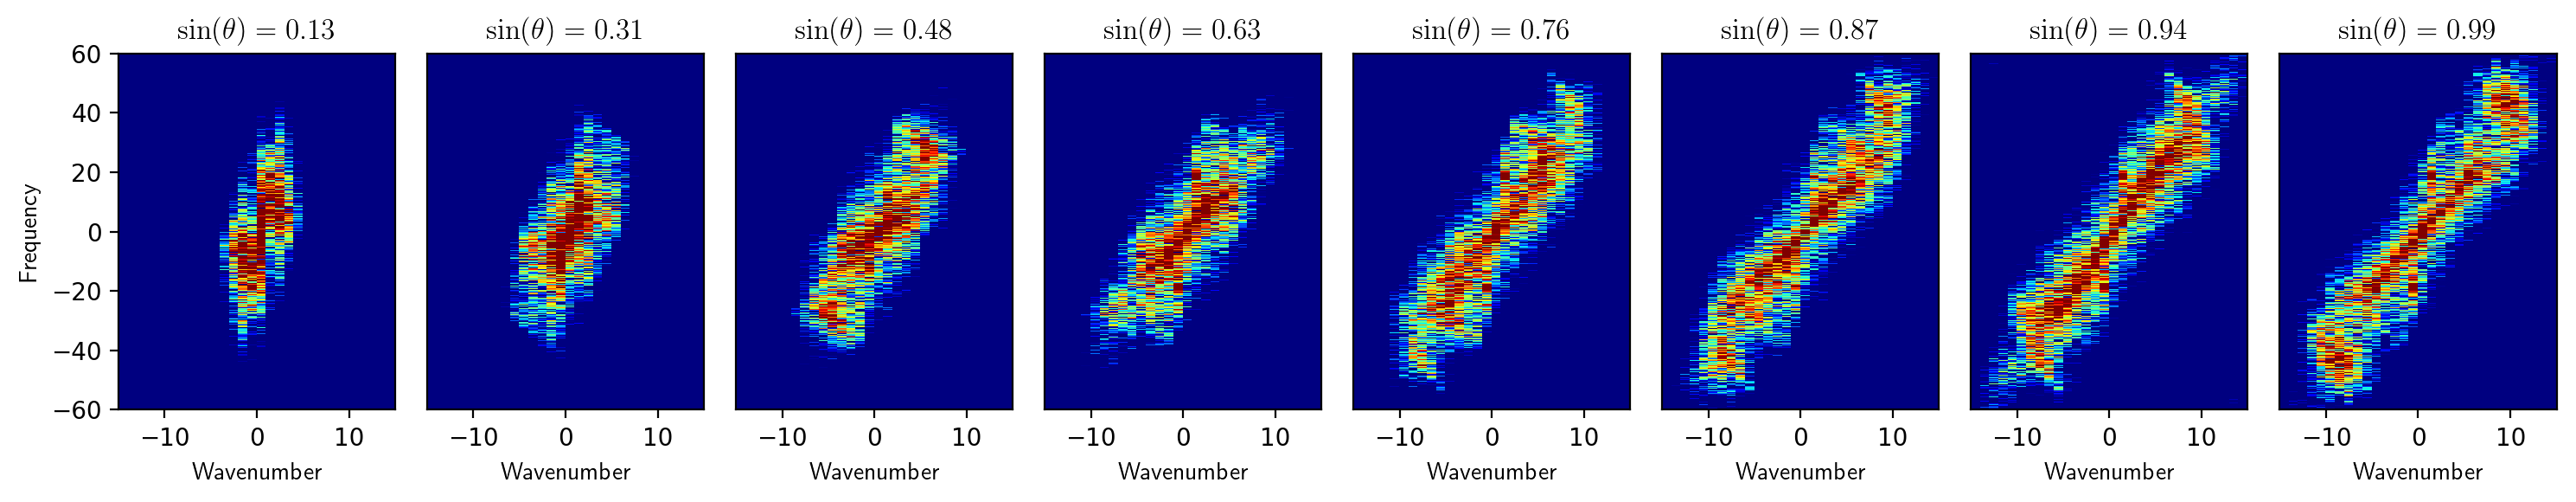

In [39]:
th_inds = np.arange(10, 128, 15, dtype=int)

plt.figure(figsize=(15, 10), dpi=300)

count = 1
for i in th_inds:
    plt.subplot(1, len(th_inds), count)
    plt.pcolormesh(phi, t_arr, vph[:,:,i] - np.mean(vph[:,:,i], axis=1, keepdims=True), cmap='jet' \
                   , vmin=-4, vmax=4)
    plt.ylim([60,80])
    if count != 1: plt.yticks([], [])
    else: plt.ylabel('Time', usetex=True)
    plt.title(r'$\sin(\theta) = %0.2f$' %(np.sin(theta[i])), usetex=True)
    plt.xlabel(r'$\phi$', usetex=True)

    count += 1

plt.tight_layout()
plt.show()

##### Plot FFT ######
plt.figure(figsize=(15, 3), dpi=200)

count = 1
for i in th_inds:
    
    sig_eq = vph[:, :, i]
    
    sig_fft = np.fft.fft2(sig_eq[500:1000, :])
    sig_fft = np.fft.fftshift(sig_fft)
    dphi = phi[2] - phi[1]
    dt = t_arr[2] - t_arr[1]

    phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
    time_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[500:1000]), d=dt))
    
    plt.subplot(1, len(th_inds), count)
    plt.pcolormesh(phi_freq, time_freq, np.log10(np.abs(sig_fft)), cmap='jet' \
                   , vmin=3, vmax=4)
    if count != 1: plt.yticks([], [])
    else: plt.ylabel('Frequency', usetex=True)
    plt.title(r'$\sin(\theta) = %0.2f$' %(np.sin(theta[i])), usetex=True)
    plt.xlabel(r'Wavenumber', usetex=True)
    
    plt.ylim([-60, 60])
    plt.xlim([-15, 15])

    count += 1

plt.tight_layout()
plt.show()

### Plot time evolution of FFT in $\phi$

In [ ]:
th_inds = np.arange(10, 128, 15, dtype=int)

plt.figure(figsize=(15, 10), dpi=300)

count = 1
for i in th_inds:
    plt.subplot(1, len(th_inds), count)
    plt.pcolormesh(phi, t_arr, vph[:,:,i] - np.mean(vph[:,:,i], axis=1, keepdims=True), cmap='jet' \
                   , vmin=-4, vmax=4)
    plt.ylim([60,80])
    if count != 1: plt.yticks([], [])
    else: plt.ylabel('Time', usetex=True)
    plt.title(r'$\sin(\theta) = %0.2f$' %(np.sin(theta[i])), usetex=True)
    plt.xlabel(r'$\phi$', usetex=True)

    count += 1

plt.tight_layout()
plt.show()

##### Plot FFT ######
plt.figure(figsize=(15, 3), dpi=200)

count = 1
for i in th_inds:
    
    sig_eq = vph[:, :, i]
    
    sig_fft = np.fft.fft2(sig_eq[500:1000, :])
    sig_fft = np.fft.fftshift(sig_fft)
    dphi = phi[2] - phi[1]
    dt = t_arr[2] - t_arr[1]

    phi_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(phi), d=dphi))
    time_freq = 2*np.pi*np.fft.fftshift(np.fft.fftfreq(len(t_arr[500:1000]), d=dt))
    
    plt.subplot(1, len(th_inds), count)
    plt.pcolormesh(phi_freq, time_freq, np.log10(np.abs(sig_fft)), cmap='jet' \
                   , vmin=3, vmax=4)
    if count != 1: plt.yticks([], [])
    else: plt.ylabel('Frequency', usetex=True)
    plt.title(r'$\sin(\theta) = %0.2f$' %(np.sin(theta[i])), usetex=True)
    plt.xlabel(r'Wavenumber', usetex=True)
    
    plt.ylim([-60, 60])
    plt.xlim([-15, 15])

    count += 1

plt.tight_layout()
plt.show()

### Find phase speed using cross-correlation

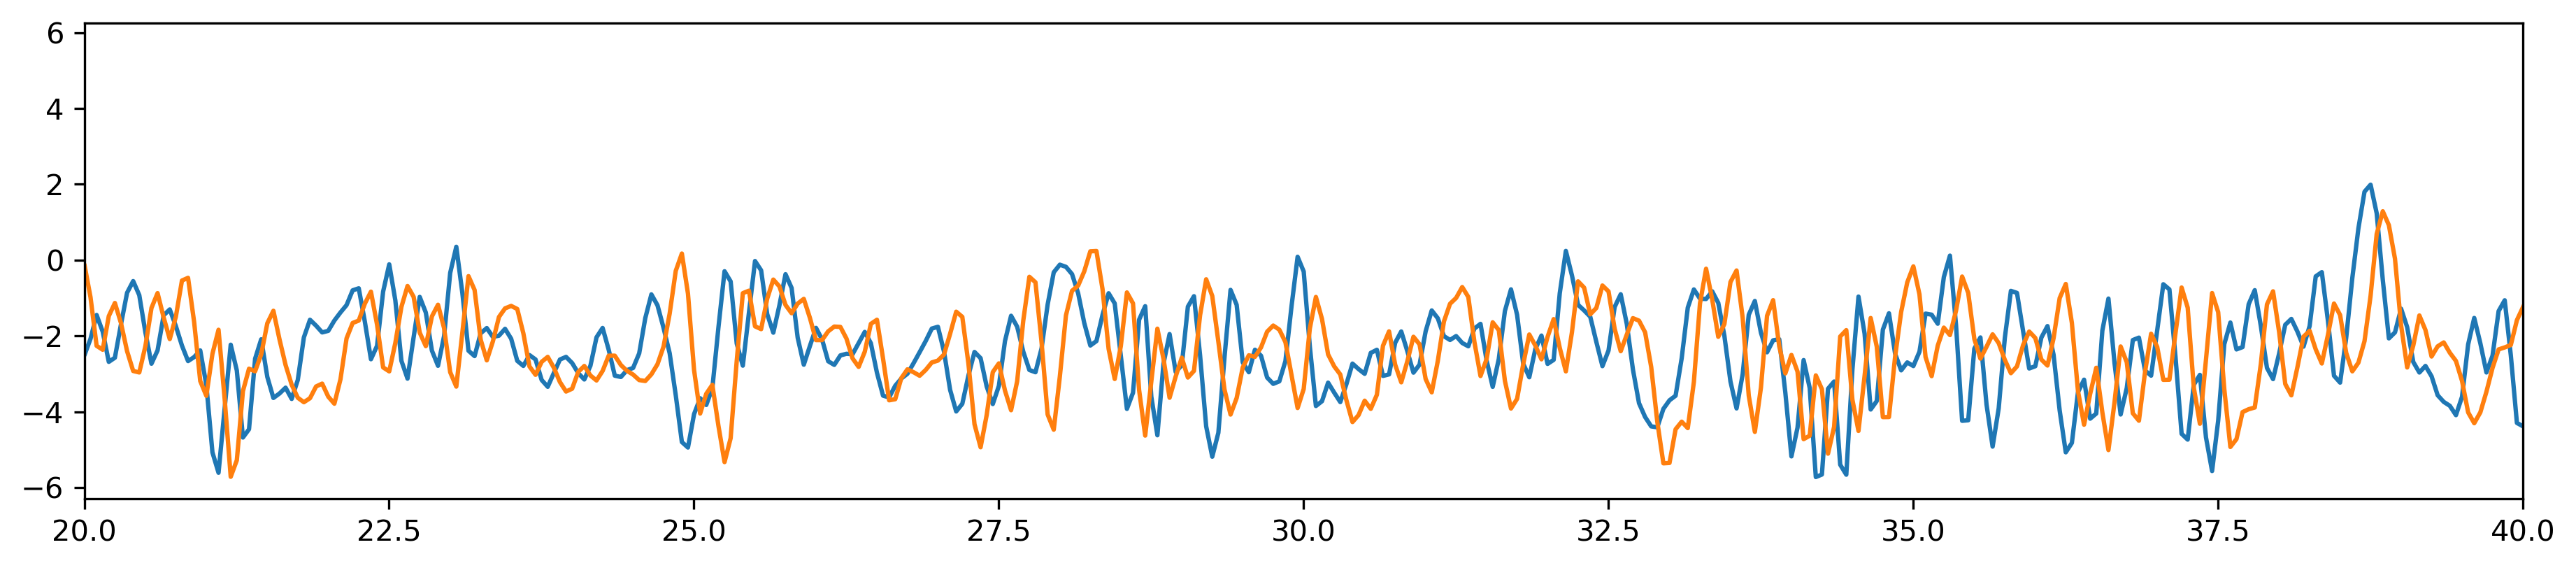

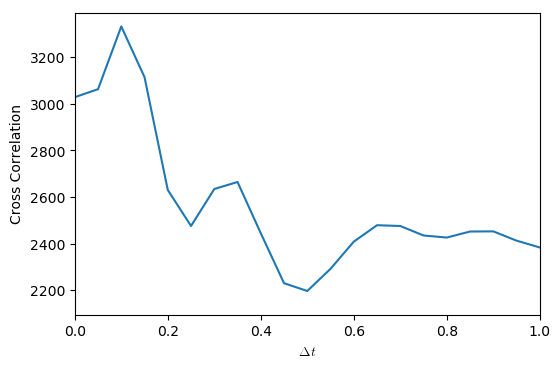

In [153]:
th_ind = 128
optimal = []

phi_ind = 120
phi_shift = 30

a = vph[:,phi_ind,th_ind]
b = vph[:-50,phi_ind - phi_shift,th_ind]

plt.figure(figsize=(15,3), dpi=300)
plt.plot(t_arr, a)
plt.plot(t_arr[:-50], b)
plt.xlim([20,40])

c = np.correlate(a-np.mean(a),b - np.mean(b))
dt = t_arr[2] - t_arr[1]

plt.figure(dpi=100)
time_shift = dt*np.arange(0,c.shape[0])
plt.plot(time_shift, c)
plt.xlabel(r'$\Delta t$', usetex=True)
plt.xlim([0, 1])
plt.ylabel('Cross Correlation')
plt.savefig('corr.pdf')

print()

In [136]:
len(b)

1950